# Project

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os, json, re, sys
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings
warnings.filterwarnings('ignore')

In [14]:
train_path = r'C:\Users\AlexanderWhite\Documents\Python Scripts\coursera ml\ai-workflow-capstone-master\cs-train'
production_path = r'C:\Users\AlexanderWhite\Documents\Python Scripts\coursera ml\ai-workflow-capstone-master\cs-production'

In [15]:
def fetch_data(data_dir):
    """
    laod all json formatted files into a dataframe
    """

    ## input testing
    if not os.path.isdir(data_dir):
        raise Exception("specified data dir does not exist")
    if not len(os.listdir(data_dir)) > 0:
        raise Exception("specified data dir does not contain any files")

    file_list = [os.path.join(data_dir,f) for f in os.listdir(data_dir) if re.search("\.json",f)]
    correct_columns = ['country', 'customer_id', 'day', 'invoice', 'month',
                       'price', 'stream_id', 'times_viewed', 'year']

    ## read data into a temp structure
    all_months = {}
    for file_name in file_list:
        df = pd.read_json(file_name)
        all_months[os.path.split(file_name)[-1]] = df

    ## ensure the data are formatted with correct columns
    for f,df in all_months.items():
        cols = set(df.columns.tolist())
        if 'StreamID' in cols:
             df.rename(columns={'StreamID':'stream_id'},inplace=True)
        if 'TimesViewed' in cols:
            df.rename(columns={'TimesViewed':'times_viewed'},inplace=True)
        if 'total_price' in cols:
            df.rename(columns={'total_price':'price'},inplace=True)

        cols = df.columns.tolist()
        if sorted(cols) != correct_columns:
            raise Exception("columns name could not be matched to correct cols")

    ## concat all of the data
    df = pd.concat(list(all_months.values()),sort=True)
    years,months,days = df['year'].values,df['month'].values,df['day'].values 
    dates = ["{}-{}-{}".format(years[i],str(months[i]).zfill(2),str(days[i]).zfill(2)) for i in range(df.shape[0])]
    df['invoice_date'] = np.array(dates,dtype='datetime64[D]')
    df['invoice'] = [re.sub("\D+","",i) for i in df['invoice'].values]
    
    ## sort by date and reset the index
    df.sort_values(by='invoice_date',inplace=True)
    df.reset_index(drop=True,inplace=True)
    
    return(df)

In [16]:
train = fetch_data(train_path)
test = fetch_data(production_path)

In [17]:
train.head()

,country,customer_id,day,invoice,month,price,stream_id,times_viewed,year,invoice_date
0,United Kingdom,13085.0,28,489434,11,6.95,85048,12,2017,2017-11-28
1,United Kingdom,13085.0,28,489434,11,6.75,79323W,12,2017,2017-11-28
2,United Kingdom,13085.0,28,489434,11,2.10,22041,21,2017,2017-11-28
3,United Kingdom,13085.0,28,489434,11,1.25,21232,5,2017,2017-11-28
4,United Kingdom,13085.0,28,489434,11,1.65,22064,17,2017,2017-11-28


In [26]:
grouped_train = train.groupby(by='invoice_date').aggregate({'price':'sum','times_viewed':'sum'}).reset_index()
grouped_test = test.groupby(by='invoice_date').aggregate({'price':'sum','times_viewed':'sum'}).reset_index()
grouped_train.set_index('invoice_date',inplace=True)
grouped_test.set_index('invoice_date',inplace=True)
grouped_train.head()

,price,times_viewed
invoice_date,,
2017-11-28,14450.54,15047
2017-11-29,13411.96,14159
2017-11-30,13290.25,15766
2017-12-01,9687.28,12524
2017-12-02,1443.26,3313


(array([17471., 17532., 17591., 17652., 17713., 17775., 17836., 17897.,
        17956., 18017., 18078.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

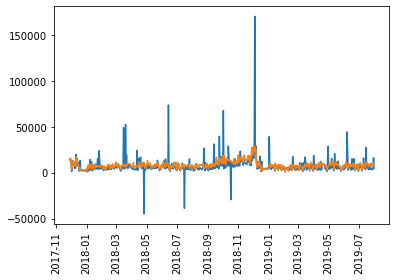

In [28]:
plt.plot(grouped_train)
plt.xticks(rotation=90)

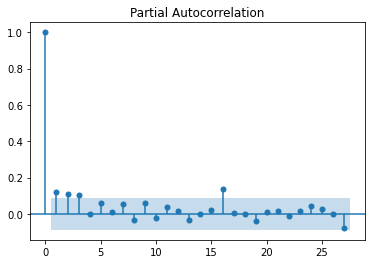

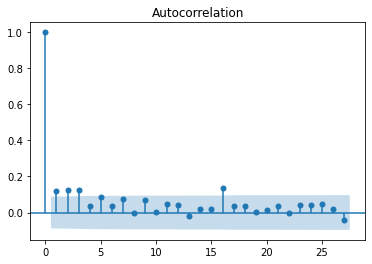

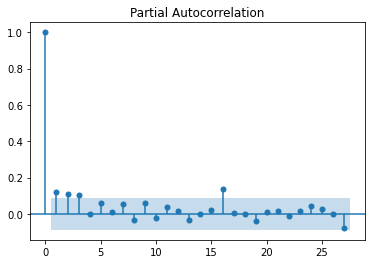

In [20]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(grouped_train['price'])
plot_pacf(grouped_train['price'])

In [10]:
model = ARIMA(grouped_train, order=(1,1,1))
results = model.fit()

                             ARIMA Model Results                              
Dep. Variable:                D.price   No. Observations:                  494
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -5293.300
Method:                       css-mle   S.D. of innovations          10872.792
Date:                Mon, 12 Apr 2021   AIC                          10594.601
Time:                        09:17:50   BIC                          10611.411
Sample:                             1   HQIC                         10601.200
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -3.7799     27.419     -0.138      0.890     -57.521      49.961
ar.L1.D.price     0.0656      0.051      1.281      0.200      -0.035       0.166
ma.L1.D.price    -0.9498      0.024    -

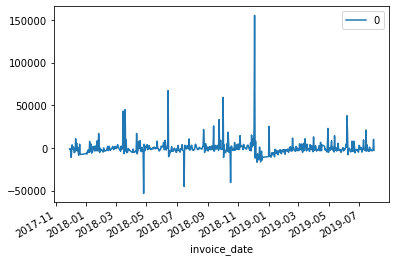

In [9]:
print(results.summary())
residuals = pd.DataFrame(results.resid)
residuals.plot()
plt.show()

In [36]:
history = [x for x in grouped_train['price']]
predictions = list()
# walk-forward validation
for t in range(len(grouped_test)):
    model = ARIMA(history, order=(1,1,4))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = grouped_test.iloc[t]
    history.append(obs)
#     print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = np.sqrt(mean_squared_error(grouped_test, predictions))
print('Test RMSE: %.3f' % rmse)
predictions.index() = grouped_test.index()
# plot forecasts against actual outcomes
plt.plot(grouped_test)
plt.plot(predictions, color='red')
plt.show()

SyntaxError: cannot assign to function call (<ipython-input-36-c1c5105efbb7>, line 16)

In [39]:
predictions.index(0:)


SyntaxError: invalid syntax (<ipython-input-39-9129fc480fec>, line 1)

In [46]:
def convert_to_ts(df_orig, country=None):
    """
    given the original DataFrame (fetch_data())
    return a numerically indexed time-series DataFrame 
    by aggregating over each day
    """

    if country:
        if country not in np.unique(df_orig['country'].values):
            raise Excpetion("country not found")
    
        mask = df_orig['country'] == country
        df = df_orig[mask]
    else:
        df = df_orig
    print(df.head)
        
    ## use a date range to ensure all days are accounted for in the data
    invoice_dates = df['invoice_date'].values
    start_month = '{}-{}'.format(df['year'].values[0],str(df['month'].values[0]).zfill(2))
    stop_month = '{}-{}'.format(df['year'].values[-1],str(df['month'].values[-1]).zfill(2))
    df_dates = df['invoice_date'].values.astype('datetime64[D]')
    days = np.arange(start_month,stop_month,dtype='datetime64[D]')
    
    purchases = np.array([np.where(df_dates==day)[0].size for day in days])
    invoices = [np.unique(df[df_dates==day]['invoice'].values).size for day in days]
    streams = [np.unique(df[df_dates==day]['stream_id'].values).size for day in days]
    views =  [df[df_dates==day]['times_viewed'].values.sum() for day in days]
    revenue = [df[df_dates==day]['price'].values.sum() for day in days]
    year_month = ["-".join(re.split("-",str(day))[:2]) for day in days]

    df_time = pd.DataFrame({'date':days,
                            'purchases':purchases,
                            'unique_invoices':invoices,
                            'unique_streams':streams,
                            'total_views':views,
                            'year_month':year_month,
                            'revenue':revenue})
#     print(purchases[:5],invoices[:5],streams[:5],views[:5],revenue[:5],year_month[:5])
    return(df_time)

In [48]:
ts_train = convert_to_ts(train)
ts_train.head(100)

<bound method NDFrame.head of                country  customer_id  day invoice  month  price stream_id  \
0       United Kingdom      13085.0   28  489434     11   6.95     85048   
1       United Kingdom      13085.0   28  489434     11   6.75    79323W   
2       United Kingdom      13085.0   28  489434     11   2.10     22041   
3       United Kingdom      13085.0   28  489434     11   1.25     21232   
4       United Kingdom      13085.0   28  489434     11   1.65     22064   
...                ...          ...  ...     ...    ...    ...       ...   
815006  United Kingdom      16098.0   31  562271      7   3.75     22725   
815007  United Kingdom      16098.0   31  562271      7   3.75     22726   
815008  United Kingdom      16098.0   31  562271      7   3.75     22727   
815009  United Kingdom      14056.0   31  562269      7   2.95     22090   
815010  United Kingdom      15628.0   31  562163      7   1.65     22558   

        times_viewed  year invoice_date  
0              

,date,purchases,unique_invoices,unique_streams,total_views,year_month,revenue
0,2017-11-01,0,0,0,0,2017-11,0.00
1,2017-11-02,0,0,0,0,2017-11,0.00
2,2017-11-03,0,0,0,0,2017-11,0.00
3,2017-11-04,0,0,0,0,2017-11,0.00
4,2017-11-05,0,0,0,0,2017-11,0.00
...,...,...,...,...,...,...,...
95,2018-02-04,844,35,558,3803,2018-02,2310.46
96,2018-02-05,1373,75,789,6617,2018-02,6838.37
97,2018-02-06,1058,58,670,6954,2018-02,3607.21
98,2018-02-07,884,38,627,2974,2018-02,4111.69


In [49]:
ts_train.to_csv(r'C:\Users\AlexanderWhite\Documents\Python Scripts\coursera ml\ai-workflow-capstone-master\cs-train\ts-data\ts-all.csv',index=False)

In [41]:
%%writefile Dockerfile

# Use an official Python runtime as a parent image
FROM python:3.8-slim-buster

RUN apt-get update && apt-get install -y \
python3-dev \
build-essential    
        
# Set the working directory to /app
WORKDIR /app

# Copy the current directory contents into the container at /app
ADD . /app

# Install any needed packages specified in requirements.txt
RUN pip install --upgrade pip
RUN pip install --no-cache-dir -r requirements.txt

# Make port 80 available to the world outside this container
EXPOSE 80

# Define environment variable
ENV NAME World

# Run app.py when the container launches
CMD ["python", "app.py"]

Overwriting Dockerfile
